# Environment Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [2]:
from patient_data_split import pat_train_test_split

# Data Loading and Setup

In [3]:
# Path to csvs that connect patient id to slices and rfs label
zero_info_path = '/Users/katyscott/Documents/ICC/Data/Labels/RFS_all_tumors_zero.csv'
nan_info_path = '/Users/katyscott/Documents/ICC/Data/Labels/RFS_all_tumors_NaN.csv'

zero_image_path = '/Users/katyscott/Documents/ICC/Data/Images/Tumors/Zero/'
nan_image_path = '/Users/katyscott/Documents/ICC/Data/Images/Tumors/NaN/'


In [4]:
# Constants for development
FILESTOLOAD = 1000
imdim = 224
random_seed = 16

In [5]:
# Reading in info for zero background images
info = pd.read_csv(zero_info_path)
image_fnames = np.asarray(info.iloc[:, 0])
pat_num = np.asarray(info.iloc[:, 1])
slice_num = np.asarray(info.iloc[:, 2])
label = np.asarray(info.iloc[:, 3])

In [27]:
label.shape

(2888,)

In [8]:
# Only loading in 100 number of files for development
images = np.empty((1,imdim,imdim))
file_count = 0
for image_file in tqdm(image_fnames):
    if file_count >= FILESTOLOAD:
        break
    else:
        file_count += 1
    #     print("Loading: ", image_file)
        # Load in file as an numpy array
        img = np.fromfile(zero_image_path + image_file)
        # Reshape image from 1D to 2D array - need to not hardcode this, square root?
        img_2D = np.reshape(img, (299, 299))
        # Scale image to this dimension, smooth image with Gaussian filter, pads with the reflection of the vector
        # mirrored on the first and last values of the vector along each axis.
        img_final = resize(img_2D, (imdim, imdim), anti_aliasing=True, mode='reflect')
        # Not sure this next line is working, want an array with all the images as their own array in it
        img_final_3D = np.reshape(img_final, (1,) + img_final.shape)
        images = np.append(images, img_final_3D, axis=0)

images = np.delete(images, 0, axis=0)

 35%|███▍      | 1000/2888 [02:30<04:43,  6.65it/s]


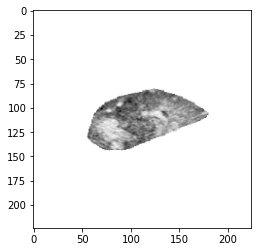

In [9]:
# Confirming images loaded in
plt.imshow(images[150], cmap='Greys')

## Splitting data for training/testing

In [22]:
# Training and testing split
train_slice_indices, test_slice_indices = pat_train_test_split(pat_num[:FILESTOLOAD], label[:FILESTOLOAD], 0.7, random_seed)

In [23]:
print("Train: ", np.array(train_slice_indices).shape)
print("Test: ", np.array(test_slice_indices).shape)

Train:  (1, 700)
Test:  (1, 300)


In [32]:
train_slices = images[train_slice_indices,:,:]#[:][:]
train_slices = train_slices.squeeze() # Remove first dim of size 1

train_labels = label[tuple(train_slice_indices)]
print("Training set: ", train_slices.shape)
print("Training labels: ", train_labels.shape)

test_slices = images[test_slice_indices,:,:]
test_slices = test_slices.squeeze() # Remove first dim of size 1

test_labels = label[tuple(test_slice_indices)]
print("Testing set: ", test_slices.shape)
print("Testing labels: ", test_labels.shape)




Training set:  (700, 224, 224)
Training labels:  (700,)
Testing set:  (300, 224, 224)
Testing labels:  (300,)


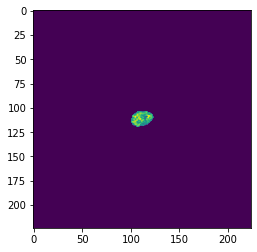

In [39]:
plt.imshow(train_slices[0])

# Model Setup

In [36]:
# Going to try a really simple model
img_in = Input(shape=(imdim, imdim,1)) # [None, imdim, imdim]

x = Conv2D(filters=8, kernel_size=5, activation='relu', padding='same')(img_in) # [None, 256, 256, 8]
# Max pooling layer, taking max value over 2x2 window 
x = MaxPool2D(pool_size=(2,2))(x) # [None, 128, 128, 8]

# Flattens tensor to vector
x = Flatten()(x) # [None, 131072]
output = Dense(1, activation='sigmoid')(x) # [None, 1]

model = Model(inputs=img_in, outputs=output, name="conv_simple")
model.compile(
        optimizer = Adam(),
        loss='binary_crossentropy',
        metrics=['BinaryAccuracy', 'AUC']
)
# model.summary()

## Model Training

In [37]:
print("Training model: " + model.name)

epochs = 10
batch_size = 32

history = model.fit(x = train_slices,
                    y = train_labels,
                    batch_size = batch_size,
                    validation_split = 0.15,
                    epochs = epochs,
                    verbose = 1 
                    )

Training model: conv_simple
Epoch 1/10
19/19 [==============================] - 3s 130ms/step - loss: 2.6690 - binary_accuracy: 0.9063 - auc: 0.5857 - val_loss: 0.0061 - val_binary_accuracy: 1.0000 - val_auc: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 2s 118ms/step - loss: 0.3531 - binary_accuracy: 0.9708 - auc: 0.6773 - val_loss: 0.0049 - val_binary_accuracy: 1.0000 - val_auc: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 2s 121ms/step - loss: 0.0992 - binary_accuracy: 0.9877 - auc: 0.8651 - val_loss: 0.0476 - val_binary_accuracy: 0.9714 - val_auc: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 2s 117ms/step - loss: 0.0671 - binary_accuracy: 0.9844 - auc: 0.9224 - val_loss: 0.0364 - val_binary_accuracy: 0.9810 - val_auc: 0.0000e+00
Epoch 5/10
19/19 [==============================] - 2s 117ms/step - loss: 0.0382 - binary_accuracy: 0.9900 - auc: 0.9251 - val_loss: 0.0601 - val_binary_accuracy: 0.9619 - val_auc: 0.0000e+00
Epoch 6/10
1

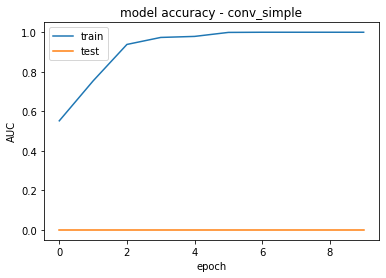

In [38]:
# Create AUC metric vs. epoch plot
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy - ' + model.name)
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()